<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/CatDogWithAlbumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached albumentations-1.0.3-py3-none-any.whl (98 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [51]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

In [52]:
class TqdmUpTo(tqdm):
  def update_to(self, b=1, bsize=1, tsize=None):
    if tsize is not None:
      self.total = tsize
    self.update(b*bsize-self.n)

In [53]:
def download_url(url, filepath):
  directory = os.path.dirname(os.path.abspath(filepath))
  os.makedirs(directory, exist_ok=True)
  if os.path.exists(filepath):
    print('Filepath already exists, Skipping download')
    return

  with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
    urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
    t.total = t.n

def extract_archive(filepath):
  extract_dir = os.path.dirname(os.path.abspath(filepath))
  shutil.unpack_archive(filepath, extract_dir)

In [54]:
dataset_directory = os.path.join(os.environ['HOME'], 'datasets/cats-vs-dogs')

In [55]:
filepath = os.path.join(dataset_directory, 'kagglecatsanddogs_3367a.zip')
download_url(
    url="https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip",
    filepath=filepath,
)
extract_archive(filepath)

Filepath already exists, Skipping download


In [56]:
root_directory = os.path.join(dataset_directory, 'PetImages')

cat_directory = os.path.join(root_directory, 'Cat')
dog_directory = os.path.join(root_directory, 'Dog')

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4936 10


In [57]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

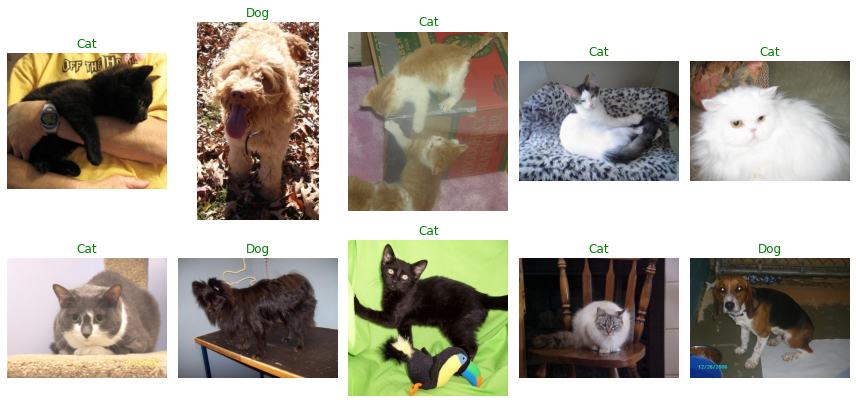

In [58]:
display_image_grid(test_images_filepaths)

In [59]:
class CatsVsDogsDataset(Dataset):
  def __init__(self, images_filepaths, transform=None):
    self.images_filepaths = images_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.images_filepaths)

  def __getitem__(self, idx):
    image_filepath = self.images_filepaths[idx]
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if os.path.normpath(image_filepath).split(os.sep)[-2] == 'Cat':
      label = 1.0
    else:
      label = 0.0
    if self.transform is not None:
      image = self.transform(image=image)['image']

    return image, label

In [60]:
train_transform = A.Compose([
                             A.SmallestMaxSize(max_size=160),
                             A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
                             A.RandomCrop(height=128, width=128),
                             A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                             A.RandomBrightnessContrast(p=0.5),
                             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                             ToTensorV2()
])

train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

In [61]:
val_transform = A.Compose([
                           A.SmallestMaxSize(max_size=160),
                           A.CenterCrop(height=128, width=128),
                           A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                           ToTensorV2()
])

val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [62]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
  dataset = copy.deepcopy(dataset)
  dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
  rows = samples // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i in range(samples):
    image, _ = dataset[idx]
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

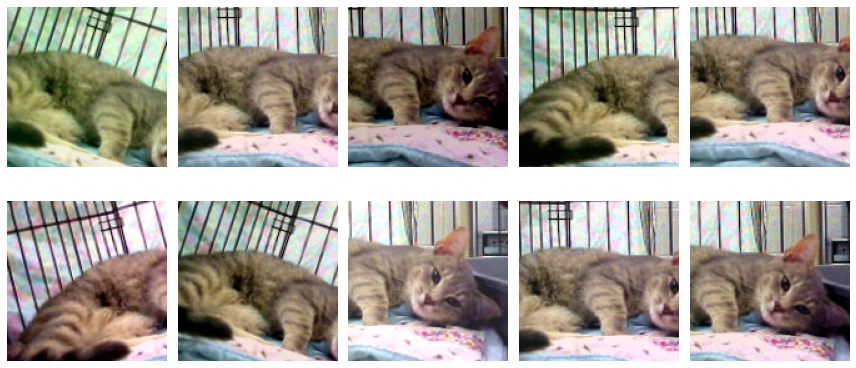

In [63]:
visualize_augmentations(train_dataset)

In [64]:
def calculate_accuracy(output, target):
  output = torch.sigmoid(output) >= 0.5
  target = target == 1.0
  return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [65]:
class MetricMonitor:
  def __init__(self, float_precision=3):
    self.float_precision = float_precision
    self.reset()

  def reset(self):
    self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

  def update(self, metric_name, val):
    metric = self.metrics[metric_name]

    metric['val'] += val
    metric['count'] += 1
    metric['avg'] = metric['val'] / metric['count']

  def __str__(self):
    return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [66]:
params = {
    'model': 'resnet50',
    'device': 'cuda',
    'lr': 0.001,
    'batch_size': 64,
    'num_workers': 4,
    'epochs': 10
}

In [67]:
!pip install madgrad

In [68]:
from madgrad import MADGRAD

In [69]:
model = getattr(models, params['model'])(pretrained=False, num_classes=1)
model = model.to(params['device'])
criterion = nn.BCEWithLogitsLoss().to(params['device'])
optimizer = MADGRAD(model.parameters(), lr=params['lr'])

In [70]:
train_loader = DataLoader(
    train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'],
    pin_memory=True
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [74]:
def train(train_loader, model, criterion, optimizer, epoch, params):
  metric_monitor = MetricMonitor()
  model.train()
  stream = tqdm(train_loader)
  for i, (images, target) in enumerate(stream, start=1):
    images = images.to(params['device'], non_blocking=True)
    target = target.to(params['device'], non_blocking=True).float().view(-1, 1)
    output = model(images)
    loss = criterion(output, target)
    accuracy = calculate_accuracy(output, target)
    metric_monitor.update('Loss', loss.item())
    metric_monitor.update('Accuracy', accuracy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [75]:
def validate(val_loader, model, criterion, epoch, params):
  metric_monitor = MetricMonitor()
  model.eval()
  stream = tqdm(val_loader)
  with torch.no_grad():
    for i, (images, target) in enumerate(stream, start=1):
      images, target = images.to(params['device'], non_blocking=True), target.to(params['device'], non_blocking=True).float().view(-1, 1)
      output = model(images)
      loss = criterion(output, target)
      accuracy = calculate_accuracy(output, target)

      metric_monitor.update('Loss', loss.item())
      metric_monitor.update('Accuracy', accuracy)
      stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [76]:
for epoch in range(1, params['epochs']+1):
  train(train_loader, model, criterion, optimizer, epoch, params)
  validate(val_loader, model, criterion, epoch, params)

Output streaming akan dipotong hingga 5000 baris terakhir.

Epoch: 9. Train.      Loss: 0.299 | Accuracy: 0.865:  90%|█████████ | 283/313 [02:19<00:14,  2.01it/s]




Epoch: 9. Train.      Loss: 0.299 | Accuracy: 0.865:  90%|█████████ | 283/313 [02:20<00:14,  2.01it/s]




Epoch: 9. Train.      Loss: 0.299 | Accuracy: 0.865:  91%|█████████ | 284/313 [02:20<00:14,  2.03it/s]




Epoch: 9. Train.      Loss: 0.299 | Accuracy: 0.865:  91%|█████████ | 284/313 [02:20<00:14,  2.03it/s]




Epoch: 9. Train.      Loss: 0.299 | Accuracy: 0.865:  91%|█████████ | 285/313 [02:20<00:13,  2.02it/s]




Epoch: 9. Train.      Loss: 0.300 | Accuracy: 0.865:  91%|█████████ | 285/313 [02:21<00:13,  2.02it/s]




Epoch: 9. Train.      Loss: 0.300 | Accuracy: 0.865:  91%|█████████▏| 286/313 [02:21<00:13,  2.02it/s]




Epoch: 9. Train.      Loss: 0.300 | Accuracy: 0.865:  91%|█████████▏| 286/313 [02:21<00:13,  2.02it/s]




Epoch: 9. Train.      Loss: 0.300 | Accuracy: 0.865:  92%|█████████▏| 287/313 [02:21